In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import pandas as pd
import numpy as np

save_dir = "../plots/lossy_compression/"

sns.set(style="whitegrid")     
paper_rc = {'lines.linewidth': 2, 'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)  

In [2]:
level_1_base_dir = "/scratch/gf332/models/relative-entropy-coding/lossy/clic2019/large_level_1_vae/"
level_2_base_dir = "/scratch/gf332/models/relative-entropy-coding/lossy/clic2019/large_level_2_vae/"

rec_kodak_stats_files = {
    "ms_ssim": {
        0.1: f"{level_2_base_dir}/ms-ssim/beta_0.003/kodak/results.csv",
        0.2: f"{level_2_base_dir}/ms-ssim/beta_0.010/kodak/results.csv",
        0.5: f"{level_2_base_dir}/ms-ssim/beta_0.030/kodak/results.csv",
        #0.8: f"{level_2_base_dir}/ms-ssim/beta_0.050/kodak/results.csv",
        1.0: f"{level_2_base_dir}/ms-ssim/beta_0.080/kodak/results.csv",
    },
    "gaussian": {
        0.1: f"{level_2_base_dir}/mse/beta_0.001_filters_196_128/kodak/results.csv",
        0.2: f"{level_2_base_dir}/mse/beta_0.003/kodak/results.csv",
        0.3: f"{level_2_base_dir}/mse/beta_0.010/kodak/results.csv",
        0.7: f"{level_2_base_dir}/mse/beta_0.030/kodak/results.csv",
        1.0: f"{level_2_base_dir}/mse/beta_0.050/kodak/results.csv",
    },
    "level-1-gaussian": {
        0.1: f"{level_1_base_dir}/mse/beta_0.001_filters_192/kodak/results.csv",
        0.2: f"{level_1_base_dir}/mse/beta_0.003_filters_192/kodak/results.csv",
        0.3: f"{level_1_base_dir}/mse/beta_0.010_filters_192/kodak/results.csv",
        0.7: f"{level_1_base_dir}/mse/beta_0.030_filters_192/kodak/results.csv",
        1.0: f"{level_1_base_dir}/mse/beta_0.100_filters_320/kodak/results.csv",
    }
}

In [3]:
level_1_gaussian_rec_dfs = []
gaussian_rec_dfs = []
ms_ssim_rec_dfs = []

for gauss_rec_bpp in sorted(rec_kodak_stats_files["level-1-gaussian"].keys()):
    
    with open(rec_kodak_stats_files["level-1-gaussian"][gauss_rec_bpp], 'r') as f:
        rec_df = pd.read_csv(f, sep=',\s+')

        rec_df = rec_df.T

        rec_df.columns = rec_df.iloc[0]

        rec_df = rec_df.drop(rec_df.index[0])
        
        rec_df.loc["loss"] = "gaussian"
        
        rec_df.loc["target_bpp"] = gauss_rec_bpp
        
        level_1_gaussian_rec_dfs.append(rec_df)

for gauss_rec_bpp in sorted(rec_kodak_stats_files["gaussian"].keys()):
    
    with open(rec_kodak_stats_files["gaussian"][gauss_rec_bpp], 'r') as f:
        rec_df = pd.read_csv(f, sep=',\s+')

        rec_df = rec_df.T

        rec_df.columns = rec_df.iloc[0]

        rec_df = rec_df.drop(rec_df.index[0])
        
        rec_df.loc["loss"] = "gaussian"
        
        rec_df.loc["target_bpp"] = gauss_rec_bpp
        
        gaussian_rec_dfs.append(rec_df)
        
for ms_ssim_rec_bpp in sorted(rec_kodak_stats_files["ms_ssim"].keys()):
    
    with open(rec_kodak_stats_files["ms_ssim"][ms_ssim_rec_bpp], 'r') as f:
        rec_df = pd.read_csv(f, sep=',\s+')

        rec_df = rec_df.T

        rec_df.columns = rec_df.iloc[0]

        rec_df = rec_df.drop(rec_df.index[0])
        
        rec_df.loc["loss"] = "ms_ssim"
        
        rec_df.loc["target_bpp"] = ms_ssim_rec_bpp
        
        ms_ssim_rec_dfs.append(rec_df)

/scratch/gf332/CWOQ/relative-entropy-coding/rec-venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/scratch/gf332/CWOQ/relative-entropy-coding/rec-venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/scratch/gf332/CWOQ/relative-entropy-coding/rec-venv/lib/python3.7/site-packages/ipykernel_launcher.py:42: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this

# Aggregate Statistics

In [4]:
psnr_base_dir = "/scratch/gf332/CWOQ/balle/compression/results/image_compression/kodak/PSNR_sRGB_RGB/"
ms_ssim_base_dir = "/scratch/gf332/CWOQ/balle/compression/results/image_compression/kodak/MS-SSIM_sRGB_RGB/"

In [130]:
psnr_method_names = {
    "jpeg420.txt": ("JPEG (4:2:0)", "MSE", 8),
    "bpg444.txt": ("BPG (4:4:4)", "MSE", 8),
    "theis-2017-iclr.txt": ("Theis (2017)", "MSE", 9),
    "balle-2018-iclr-opt-mse.txt": ("Ballé (2018) (opt. for MSE)", "MSE", 9),
    "balle-2018-iclr-opt-msssim.txt": ("Ballé (2018) (opt. for MS-SSIM)", "MS-SSIM", 9),
    #"minnen-2018-neurips.txt": ("Minnen (2018)", "MSE", 9),
    "minnen-2020-icip.txt": ("Minnen (2020)", "MSE", 9),
}

ms_ssim_method_names = {
    "jpeg420.txt": ("JPEG (4:2:0)", "MSE", 10),
    "bpg444.txt": ("BPG (4:4:4)", "MSE", 10),
    "theis-2017-iclr.txt": ("Theis (2017)", "MSE", 11),
    "balle-2018-iclr-opt-mse.txt": ("Ballé (2018) (opt. for MSE)", "MSE", 11),
    "balle-2018-iclr-opt-msssim.txt": ("Ballé (2018) (opt. for MS-SSIM)", "MS-SSIM",  11),
    "minnen-2018-neurips.txt": ("Minnen (2018)", "MSE", 11),
}

In [131]:
def prepare_method_df(metric, method_name, method_legend, skiprows, opt_objective):
    
    base_dir = psnr_base_dir if metric == "psnr" else ms_ssim_base_dir
    
    df = pd.read_csv(f"{base_dir}/{method_name}", 
                                   skiprows=skiprows, 
                                   header=0, 
                                   names=["bpp", metric])
    
    df["objective"] = opt_objective
    df["method"] = method_legend
    
    df = df.astype({metric: float,
                    "bpp": float})
    
    if metric == "ms_ssim":
        df["ms_ssim"] = to_db(df["ms_ssim"])
    
    df = df[df["bpp"] < 2]
    
    return df

to_db = lambda x: -10. * np.log10(1. - x)

In [132]:
def get_rec_psnr_average_df(rec_dfs, kind):
    aggregate_df = pd.concat(rec_dfs, axis=1)
    aggregate_df = aggregate_df.T.astype({
        "comp_lossy_BPP": float,
        "lossy_BPP": float,
        "ideal_PSNR": float,
        "PSNR": float,
        "ideal_MS_SSIM": float,
        "MS_SSIM": float,
    })

    psnr_avg_df = aggregate_df.groupby("target_bpp").mean().rename({"PSNR": "psnr",
                                                                 "comp_lossy_BPP": "bpp",
                                                                 "MS_SSIM": "ms_ssim"}, axis=1)
    psnr_avg_df["model"] = f"REC {kind}"
    psnr_avg_df["type"] = f"actual"
    

    ideal_psnr_avg_df = aggregate_df.groupby("target_bpp").mean().rename({"ideal_PSNR": "psnr",
                                                                 "lossy_BPP": "bpp",
                                                                 "ideal_MS_SSIM": "ms_ssim"}, axis=1)
    ideal_psnr_avg_df["model"] = f"REC {kind}"
    ideal_psnr_avg_df["type"] = f"ideal"
    
    return pd.concat([psnr_avg_df, ideal_psnr_avg_df])

In [133]:
rec_l1_gaussian_psnr_avg_df = get_rec_psnr_average_df(level_1_gaussian_rec_dfs, "1-Level (MSE objective)")
rec_gaussian_psnr_avg_df  = get_rec_psnr_average_df(gaussian_rec_dfs, "2-Level (MSE objective)")
rec_ms_ssim_psnr_avg_df = get_rec_psnr_average_df(ms_ssim_rec_dfs, "2-Level (MS-SSIM objective)")

In [134]:
psnr_results = pd.concat([prepare_method_df("psnr", method_name, method_legend, skiprows, opt_objective)
                for method_name, (method_legend, opt_objective, skiprows) in psnr_method_names.items()])

ms_ssim_results = pd.concat([prepare_method_df("ms_ssim", method_name, method_legend, skiprows, opt_objective)
                for method_name, (method_legend, opt_objective, skiprows) in ms_ssim_method_names.items()])

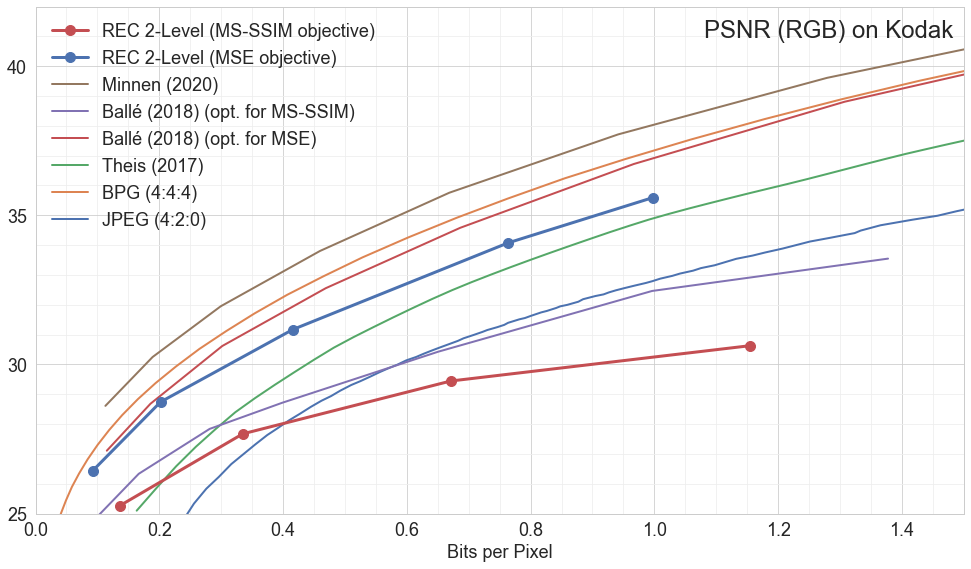

In [210]:
fig, ax = plt.subplots(figsize=(14, 8))

sns.lineplot(x="bpp", 
             y="psnr", 
             data=psnr_results,
             markers=False,
             dashes=False,
             hue='method',
             ax=ax)

rec_psnr_df = rec_gaussian_psnr_avg_df[rec_gaussian_psnr_avg_df["type"] == "actual"].rename({"model": "method"}, axis=1)
ax.plot(rec_psnr_df["bpp"], rec_psnr_df["psnr"], label=rec_psnr_df["method"].values[0], marker="o", linewidth=3, c='b')

rec_ssim_df = rec_ms_ssim_psnr_avg_df[rec_ms_ssim_psnr_avg_df["type"] == "actual"].rename({"model": "method"}, axis=1)
ax.plot(rec_ssim_df["bpp"], rec_ssim_df["psnr"], label=rec_ssim_df["method"].values[0], marker="o", linewidth=3, c='r')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:][::-1], 
          labels=labels[1:][::-1], 
          fontsize=18,
          loc="upper left",
          title=None,
          fancybox=False,
          frameon=False)

ax.set_xlim([0, 1.5])
ax.set_ylim([25, 42])
ax.set_ylabel(None)
ax.set_xlabel("Bits per Pixel", fontsize=18)

ax.tick_params(axis='both', which='major', labelsize=18)

x_major_ticks = np.arange(0., 1.5, 0.2)
x_minor_ticks = np.arange(0., 1.5, 0.05)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)

y_major_ticks = np.arange(25., 42, 5)
y_minor_ticks = np.arange(25., 42, 1)

ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

ax.grid(which='major', alpha=1)
ax.grid(which='minor', c="#eeeeee", alpha=1)

ax.text(.72, .94, 'PSNR (RGB) on Kodak',
        horizontalalignment='left',
        transform=ax.transAxes,
        fontsize=24)

fig.tight_layout()

fig.savefig(f"{save_dir}/method_psnr_comparison.eps")

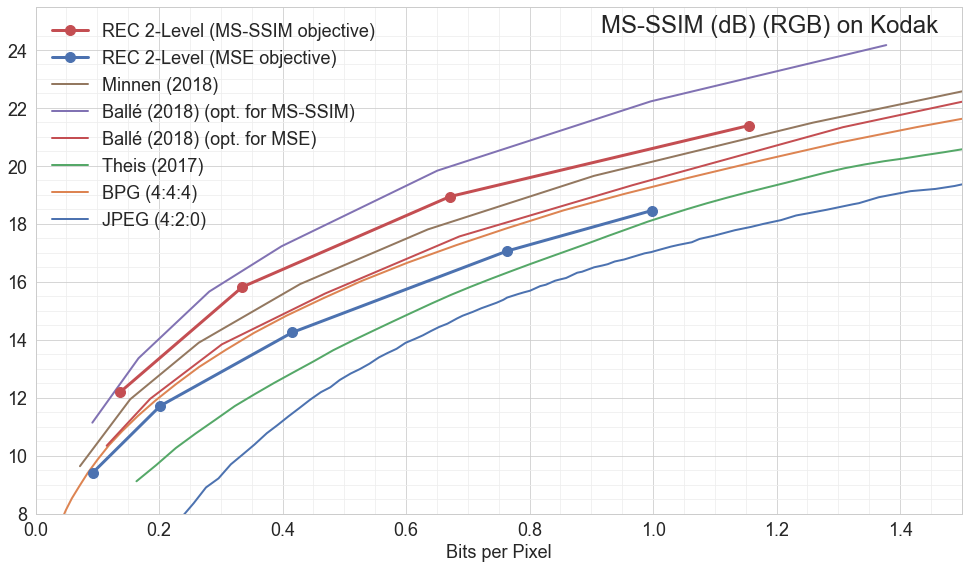

In [211]:
fig, ax = plt.subplots(figsize=(14, 8))


sns.lineplot(x="bpp", 
             y="ms_ssim", 
             data=ms_ssim_results,
             markers=False,
             dashes=False,
             hue='method',
             ax=ax)

rec_psnr_df = rec_gaussian_psnr_avg_df[rec_gaussian_psnr_avg_df["type"] == "actual"].rename({"model": "method"}, axis=1)
ax.plot(rec_psnr_df["bpp"], to_db(rec_psnr_df["ms_ssim"]), label=rec_psnr_df["method"].values[0], marker="o", linewidth=3, c='b')

rec_ssim_df = rec_ms_ssim_psnr_avg_df[rec_ms_ssim_psnr_avg_df["type"] == "actual"].rename({"model": "method"}, axis=1)
ax.plot(rec_ssim_df["bpp"], to_db(rec_ssim_df["ms_ssim"]), label=rec_ssim_df["method"].values[0], marker="o", linewidth=3, c='r')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:][::-1], 
          labels=labels[1:][::-1], 
          fontsize=18,
          loc="upper left",
          title=None,
          fancybox=False,
          frameon=False)

ax.set_xlim([0, 1.5])
ax.set_ylim([8, 25.5])
ax.set_xlabel("Bits per Pixel", fontsize=18)
ax.set_ylabel(None)

ax.tick_params(axis='both', which='major', labelsize=18)

x_major_ticks = np.arange(0., 1.5, 0.2)
x_minor_ticks = np.arange(0., 1.5, 0.05)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)

y_major_ticks = np.arange(8., 25, 2)
y_minor_ticks = np.arange(8., 25, 0.5)

ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

ax.grid(which='major', alpha=1)
ax.grid(which='minor', c="#eeeeee", alpha=1)

ax.text(.61, .95, 'MS-SSIM (dB) (RGB) on Kodak',
        horizontalalignment='left',
        transform=ax.transAxes,
        fontsize=24)

fig.tight_layout()

fig.savefig(f"{save_dir}/method_ms_ssim_comparison.eps")

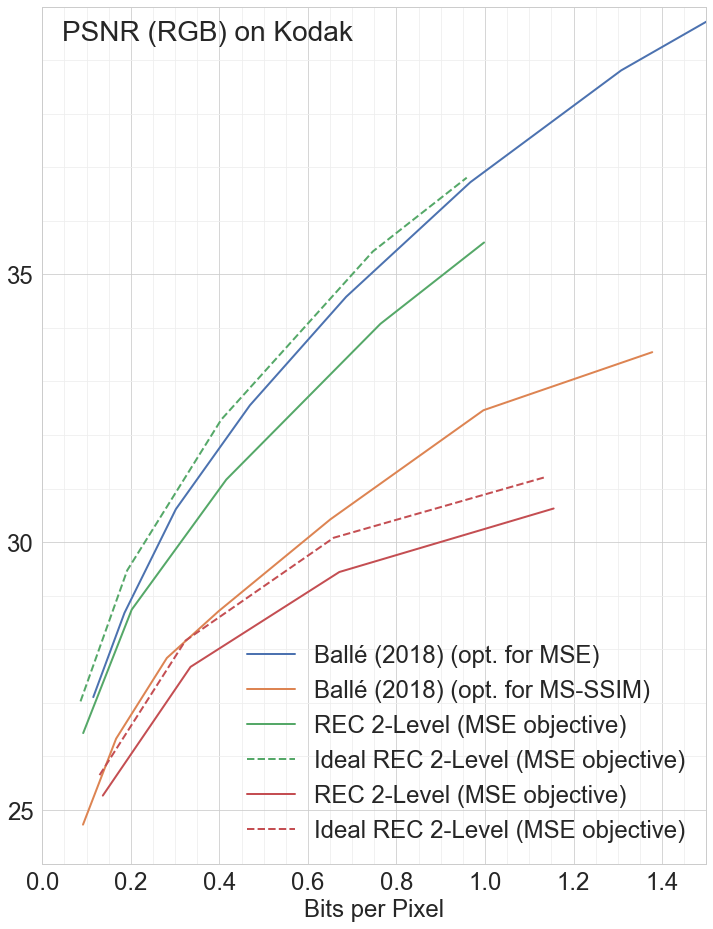

In [224]:
fig, ax = plt.subplots(figsize=(10, 13))

balle_psnr_results = psnr_results[psnr_results["method"].str.contains("Ballé")]

sns.lineplot(x="bpp", 
             y="psnr", 
             data=balle_psnr_results,
             markers=False,
             dashes=False,
             hue='method',
             ax=ax)

rec_psnr_df = rec_gaussian_psnr_avg_df[rec_gaussian_psnr_avg_df["type"] == "actual"].rename({"model": "method"}, axis=1)
ax.plot(rec_psnr_df["bpp"], 
        rec_psnr_df["psnr"], 
        label="REC 2-Level (MSE objective)", 
        linewidth=2, 
        c='g')

ideal_rec_psnr_df = rec_gaussian_psnr_avg_df[rec_gaussian_psnr_avg_df["type"] == "ideal"].rename({"model": "method"}, axis=1)
ax.plot(ideal_rec_psnr_df["bpp"], 
        ideal_rec_psnr_df["psnr"], 
        label="Ideal REC 2-Level (MSE objective)",
        marker="", 
        linewidth=2, 
        c='g', 
        linestyle="--")


rec_psnr_df = rec_ms_ssim_psnr_avg_df[rec_ms_ssim_psnr_avg_df["type"] == "actual"].rename({"model": "method"}, axis=1)
ax.plot(rec_psnr_df["bpp"], 
        rec_psnr_df["psnr"], 
        label="REC 2-Level (MSE objective)", 
        linewidth=2, 
        c='r')

ideal_rec_psnr_df = rec_ms_ssim_psnr_avg_df[rec_ms_ssim_psnr_avg_df["type"] == "ideal"].rename({"model": "method"}, axis=1)
ax.plot(ideal_rec_psnr_df["bpp"], 
        ideal_rec_psnr_df["psnr"], 
        label="Ideal REC 2-Level (MSE objective)",
        marker="", 
        linewidth=2, 
        c='r', 
        linestyle="--")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], 
          labels=labels[1:], 
          fontsize=24,
          loc="lower right",
          title=None,
          fancybox=False,
          frameon=False)

ax.set_xlim([0, 1.5])
ax.set_ylim([24, 40])
ax.set_xlabel("Bits per Pixel", fontsize=24)
ax.set_ylabel(None)

ax.tick_params(axis='both', which='major', labelsize=24)

x_major_ticks = np.arange(0., 1.5, 0.2)
x_minor_ticks = np.arange(0., 1.5, 0.05)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)

y_major_ticks = np.arange(25., 40, 5)
y_minor_ticks = np.arange(24., 40, 1)

ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

ax.grid(which='major', alpha=1)
ax.grid(which='minor', c="#eeeeee", alpha=1)

ax.text(.03, .96, 'PSNR (RGB) on Kodak',
        horizontalalignment='left',
        transform=ax.transAxes,
        fontsize=28)

fig.tight_layout()
fig.savefig(f"{save_dir}/actual_vs_ideal_psnr_comparison.eps")

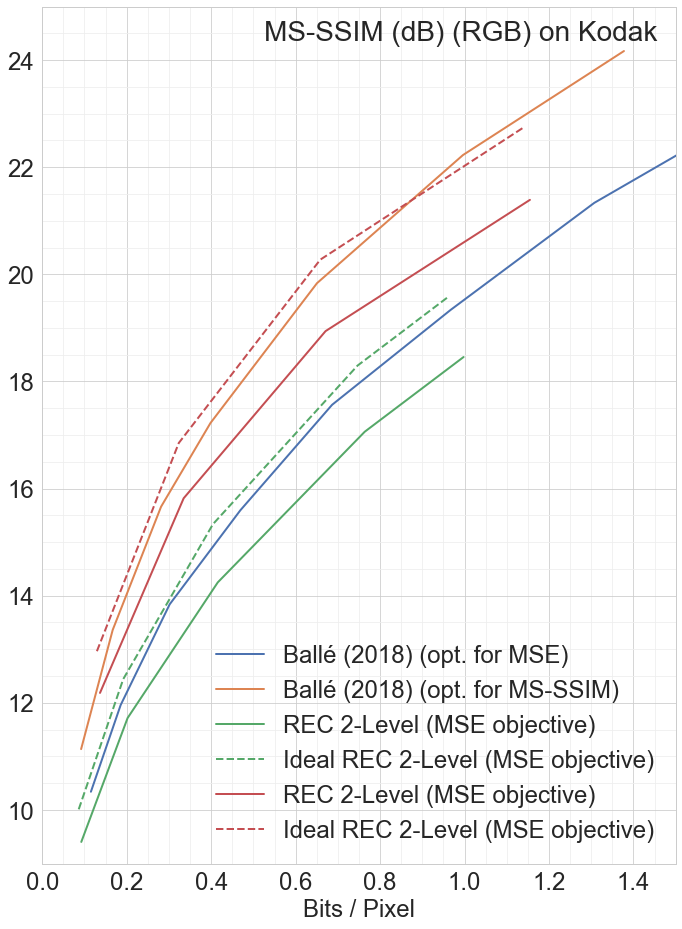

In [218]:
fig, ax = plt.subplots(figsize=(10, 13))

balle_ms_ssim_results = ms_ssim_results[ms_ssim_results["method"].str.contains("Ballé")]


sns.lineplot(x="bpp", 
             y="ms_ssim", 
             data=balle_ms_ssim_results,
             markers=False,
             dashes=False,
             hue='method',
             ax=ax)

rec_psnr_df = rec_gaussian_psnr_avg_df[rec_gaussian_psnr_avg_df["type"] == "actual"].rename({"model": "method"}, axis=1)
ax.plot(rec_psnr_df["bpp"], 
        to_db(rec_psnr_df["ms_ssim"]), 
        label="REC 2-Level (MSE objective)", 
        linewidth=2, 
        c='g')

ideal_rec_psnr_df = rec_gaussian_psnr_avg_df[rec_gaussian_psnr_avg_df["type"] == "ideal"].rename({"model": "method"}, axis=1)
ax.plot(ideal_rec_psnr_df["bpp"], 
        to_db(ideal_rec_psnr_df["ms_ssim"]), 
        label="Ideal REC 2-Level (MSE objective)",
        marker="", 
        linewidth=2, 
        c='g', 
        linestyle="--")


rec_psnr_df = rec_ms_ssim_psnr_avg_df[rec_ms_ssim_psnr_avg_df["type"] == "actual"].rename({"model": "method"}, axis=1)
ax.plot(rec_psnr_df["bpp"], 
        to_db(rec_psnr_df["ms_ssim"]), 
        label="REC 2-Level (MSE objective)", 
        linewidth=2, 
        c='r')

ideal_rec_psnr_df = rec_ms_ssim_psnr_avg_df[rec_ms_ssim_psnr_avg_df["type"] == "ideal"].rename({"model": "method"}, axis=1)
ax.plot(ideal_rec_psnr_df["bpp"], 
        to_db(ideal_rec_psnr_df["ms_ssim"]), 
        label="Ideal REC 2-Level (MSE objective)",
        marker="", 
        linewidth=2, 
        c='r', 
        linestyle="--")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], 
          labels=labels[1:], 
          fontsize=24,
          loc="lower right",
          title=None,
          fancybox=False,
          frameon=False)

ax.set_xlim([0, 1.5])
ax.set_ylim([9, 25])
ax.set_xlabel("Bits / Pixel", fontsize=24)
ax.set_ylabel(None)

ax.tick_params(axis='both', which='major', labelsize=24)

x_major_ticks = np.arange(0., 1.5, 0.2)
x_minor_ticks = np.arange(0., 1.5, 0.05)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)

y_major_ticks = np.arange(10., 25, 2)
y_minor_ticks = np.arange(10., 25, 0.5)

ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

ax.grid(which='major', alpha=1)
ax.grid(which='minor', c="#eeeeee", alpha=1)

ax.text(.35, .96, 'MS-SSIM (dB) (RGB) on Kodak',
        horizontalalignment='left',
        transform=ax.transAxes,
        fontsize=28)

fig.tight_layout()
fig.savefig(f"{save_dir}/actual_vs_ideal_ms_ssim_comparison.eps")

# Individual Images

In [8]:
img_name = 'kodim11.png'

jpeg_img_df = pd.read_json(jpeg_df[img_name].to_json())
balle_img_df = pd.read_json(balle_df[img_name].to_json())

jpeg_img_df.loc["model"] = "jpeg"
balle_img_df.loc["model"] = "balle"

# Put the columns in order
jpeg_img_df = jpeg_img_df.reindex(sorted(jpeg_img_df.columns, key=lambda c: int(c.split('_')[1])), axis=1)
balle_img_df = balle_img_df.reindex(sorted(balle_img_df.columns, 
                                           key=lambda c: float(f"0.{c.split('_')[1]}")), axis=1)

ideal_rec_df = pd.DataFrame(rec_df[img_name].apply(float))
actual_rec_df = ideal_rec_df.copy()

ideal_rec_df = ideal_rec_df.rename({"ideal_PSNR": "psnr",
                                    "lossy_BPP": "bpp",
                                    "ideal_MS_SSIM": "ms_ssim"}).loc[["psnr", "bpp", "ms_ssim"]]

actual_rec_df = actual_rec_df.rename({"PSNR": "psnr",
                                     "comp_lossy_BPP": "bpp",
                                     "MS_SSIM": "ms_ssim"}).loc[["psnr", "bpp", "ms_ssim"]]

ideal_rec_df.loc["model"] = "ideal_rec"
actual_rec_df.loc["model"] = "actual_rec"

In [9]:
joint_df = pd.concat([jpeg_img_df, 
                      balle_img_df, 
                      ideal_rec_df, 
                      actual_rec_df], axis=1).T.astype({"bpp": float,
                                                        "psnr": float,
                                                        "ms_ssim": float})

In [10]:
# Convert MS-SSIM statistic to decibels
joint_df['ms_ssim'] = -10 * np.log(1 - joint_df['ms_ssim'])

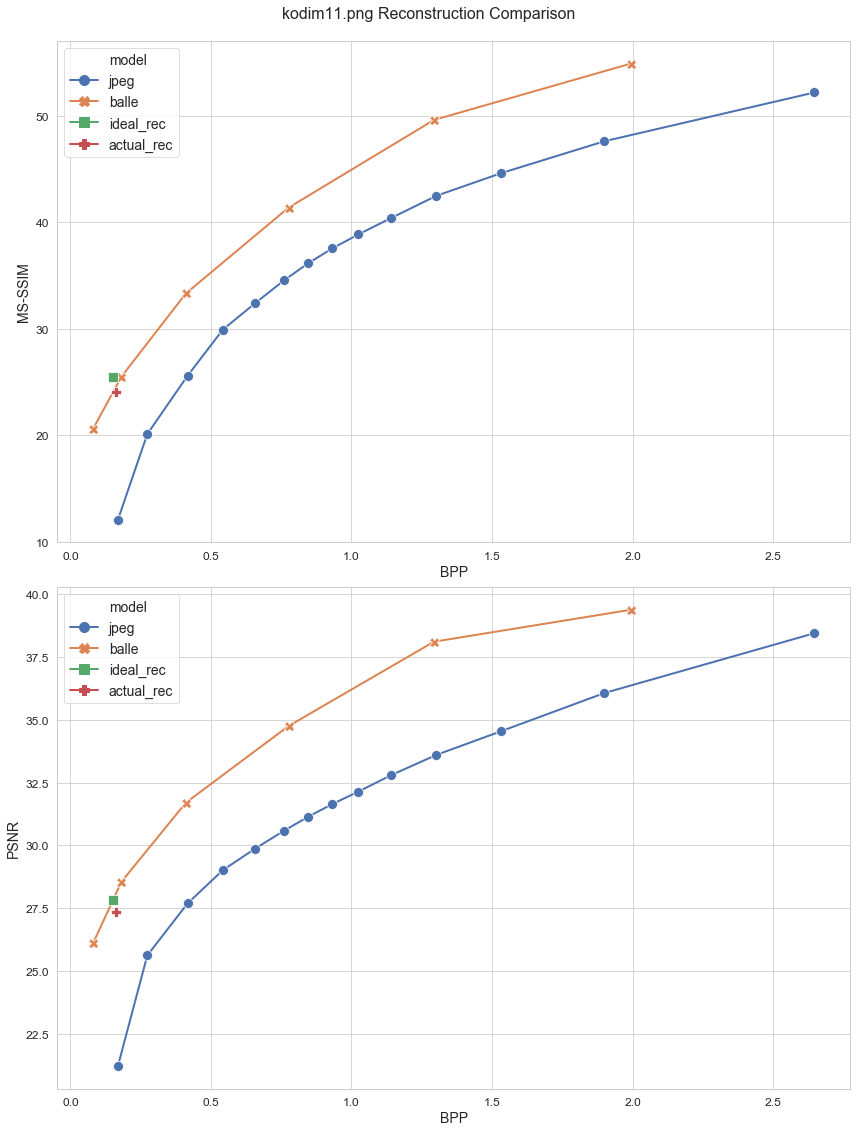

In [20]:
plot_joint_statistics(joint_df, img_name, psnr=True)